In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.metrics import MAPE
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional

Using TensorFlow backend.


In [2]:
casediff = pd.read_csv("casediff.csv", index_col=0)
deathdiff = pd.read_csv("deathdiff.csv", index_col=0)

In [3]:
casediff.columns

Index(['Belgium', 'Chile', 'China (People's Republic of)', 'Greece', 'India',
       'Ireland', 'Israel', 'Spain', 'Turkey', 'United Kingdom',
       'United States'],
      dtype='object')

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

def lstmseq(raw_seq,n_steps=7):
    X, y = split_sequence(raw_seq, n_steps)
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=200, verbose=0)
    
def lstmbi(raw_seq,n_steps=7):
    X, y = split_sequence(raw_seq, n_steps)
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(n_steps, n_features))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=200, verbose=0)
    
def normtest(raw_seq):
    stat, p = stats.normaltest(raw_seq)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Data looks Gaussian (fail to reject H0)')
    else:
        print('Data does not look Gaussian (reject H0)')
    sns.distplot(raw_seq);
    print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(raw_seq)))
    print( 'Skewness of normal distribution: {}'.format(stats.skew(raw_seq)))
    df1=raw_seq
    df1.plot(figsize=(12,5))
    plt.ylabel('Rate of change per 100k')
    plt.legend().set_visible(False)
    plt.tight_layout()
    plt.title('Covid Time Series')
    sns.despine(top=True)
    plt.show();
    
def lstmseq2(raw_seq,look_back=14):
    dataset = raw_seq.values
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    train_size = int(len(dataset) * 0.80)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mape', optimizer='adam', metrics=['MAPE'])
    history = model.fit(X_train, Y_train, epochs=100, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)
    model.summary()
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    train_predict = scaler.inverse_transform(train_predict)
    Y_train = scaler.inverse_transform([Y_train])
    test_predict = scaler.inverse_transform(test_predict)
    Y_test = scaler.inverse_transform([Y_test])
    print('Train Mean Absolute Percentage Error:', MAPE(Y_train[0], train_predict[:,0]).numpy())
    print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
    print('Test Mean Absolute Percentage Error:', MAPE(Y_test[0], test_predict[:,0]).numpy())
    print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
    return history, test_predict, Y_test

def lstmbi2(raw_seq,look_back=14):
    dataset = raw_seq.values
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    train_size = int(len(dataset) * 0.80)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    model = Sequential()
    model.add(Bidirectional(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]))))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mape', optimizer='adam', metrics=['MAPE'])
    history = model.fit(X_train, Y_train, epochs=100, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)
    model.summary()
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    train_predict = scaler.inverse_transform(train_predict)
    Y_train = scaler.inverse_transform([Y_train])
    test_predict = scaler.inverse_transform(test_predict)
    Y_test = scaler.inverse_transform([Y_test])
    print('Train Mean Absolute Percentage Error:', MAPE(Y_train[0], train_predict[:,0]).numpy())
    print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
    print('Test Mean Absolute Percentage Error:', MAPE(Y_test[0], test_predict[:,0]).numpy())
    print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
    return history, test_predict, Y_test

Belgium
Statistics=237.647, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 9.041908676070287
Skewness of normal distribution: 3.0027701224904213


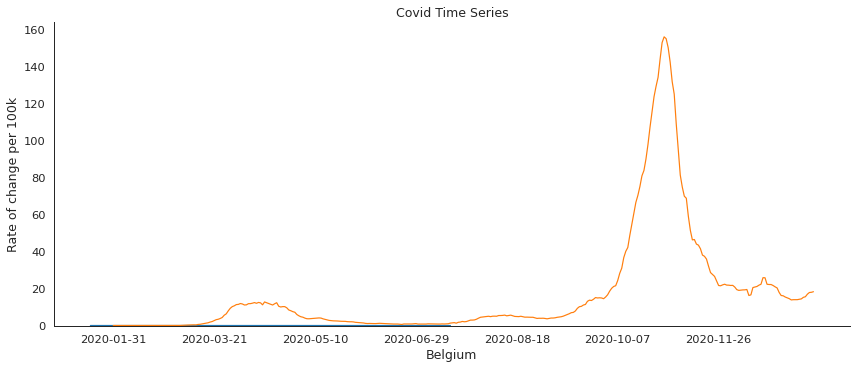

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               46000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 2320758.0
Train Root Mean Squared Error: 5.286874181150762
Test Mean Absolute Percentage Error: 24.499043
Test Root Mean Squared Error: 8.443525846144787


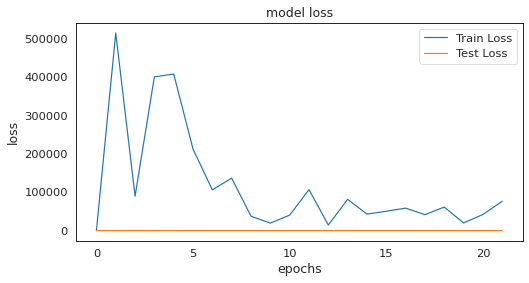

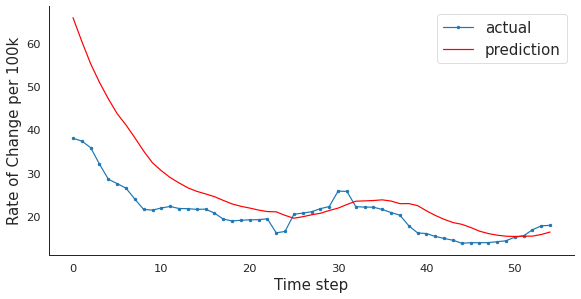

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 200)               92000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 16321795.0
Train Root Mean Squared Error: 5.375828825416622
Test Mean Absolute Percentage Error: 27.192104
Test Root Mean Squared Error: 9.00192495100518


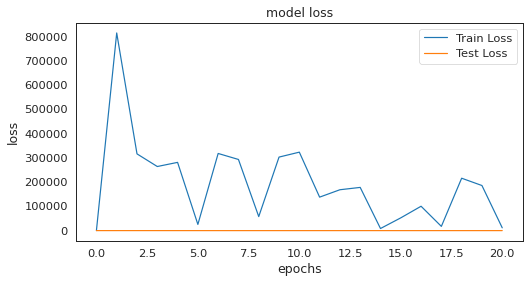

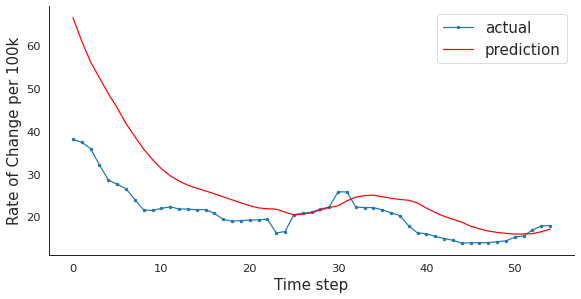

Chile
Statistics=66.014, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 1.1402225567657691
Skewness of normal distribution: 1.1865721038567636


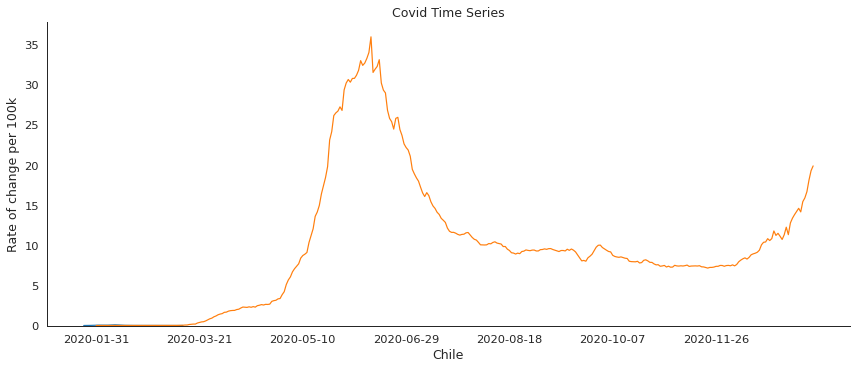

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               46000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 2959660.2
Train Root Mean Squared Error: 2.56947098494032
Test Mean Absolute Percentage Error: 11.247728
Test Root Mean Squared Error: 1.7652343278474907


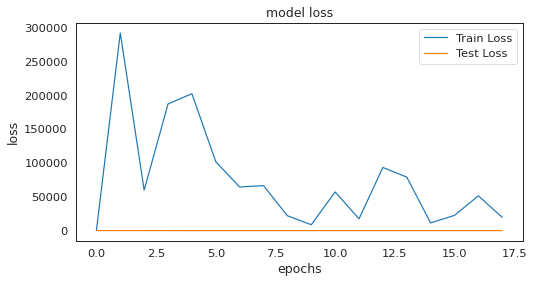

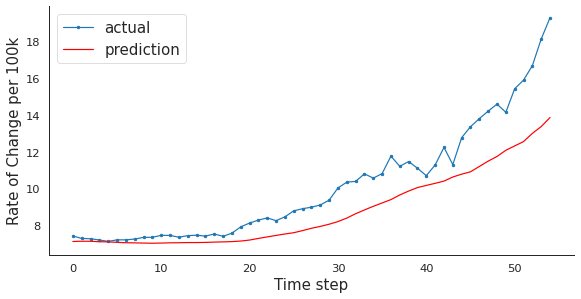

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 200)               92000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 4736981.0
Train Root Mean Squared Error: 2.848670127989857
Test Mean Absolute Percentage Error: 11.835963
Test Root Mean Squared Error: 1.887698298410997


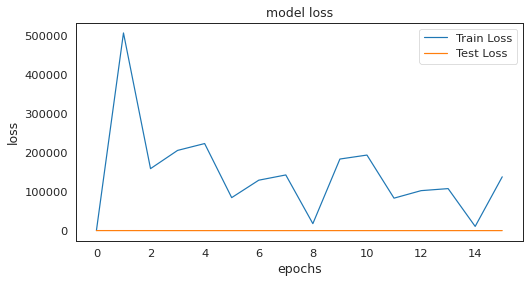

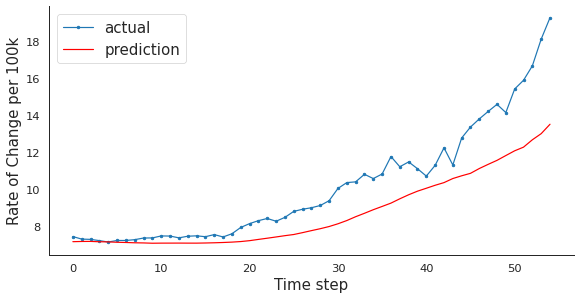

China (People's Republic of)
Statistics=313.878, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 15.703735874430773
Skewness of normal distribution: 4.046493922433115


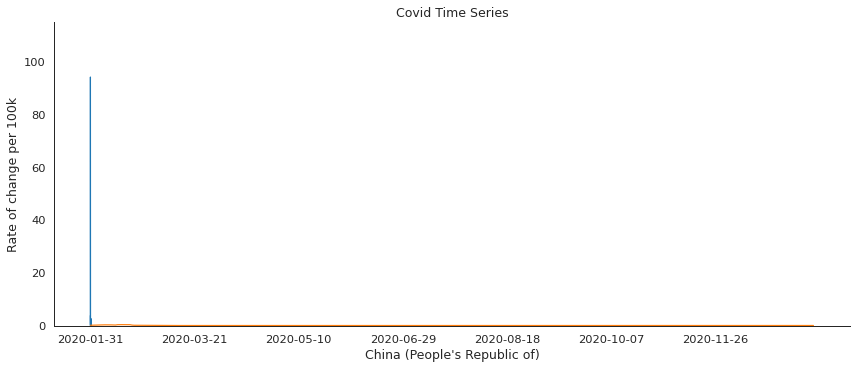

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               46000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 80.766594
Train Root Mean Squared Error: 0.04017140251178055
Test Mean Absolute Percentage Error: 89.8758
Test Root Mean Squared Error: 0.005829258946444853


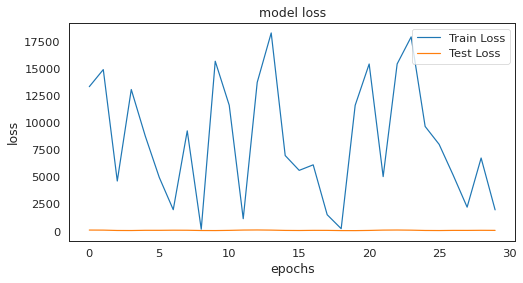

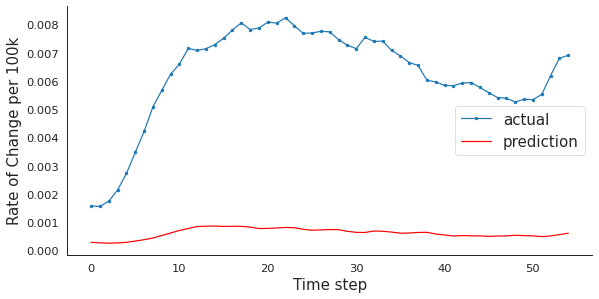

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 200)               92000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 57.021618
Train Root Mean Squared Error: 0.037656472806951814
Test Mean Absolute Percentage Error: 69.10552
Test Root Mean Squared Error: 0.0046807171615099695


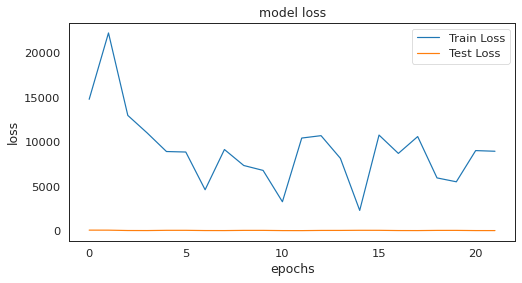

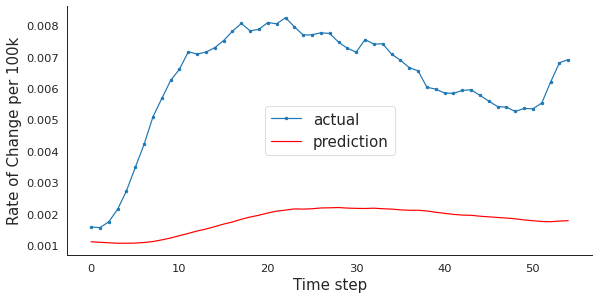

Greece
Statistics=136.281, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 2.8655607849090963
Skewness of normal distribution: 1.9714660770965662


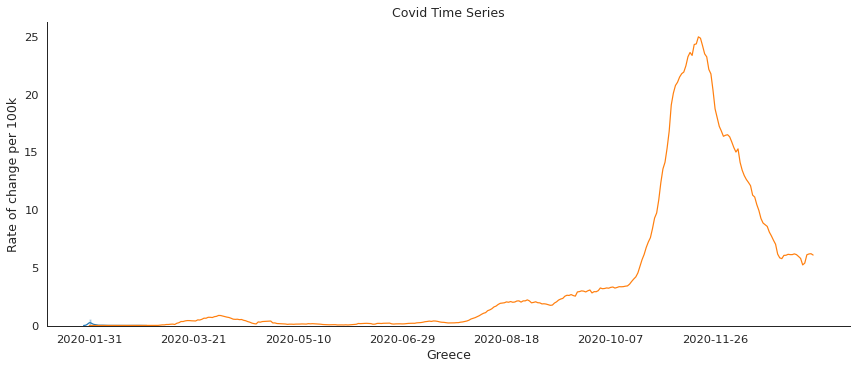

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100)               46000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 475965.97
Train Root Mean Squared Error: 0.73808839529442
Test Mean Absolute Percentage Error: 44.386185
Test Root Mean Squared Error: 6.234283642765062


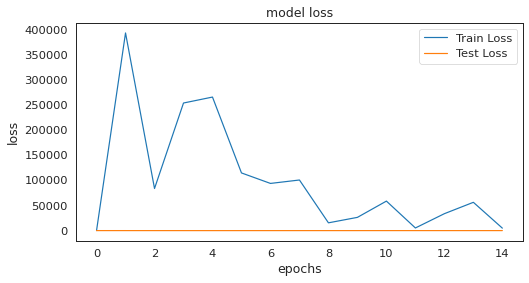

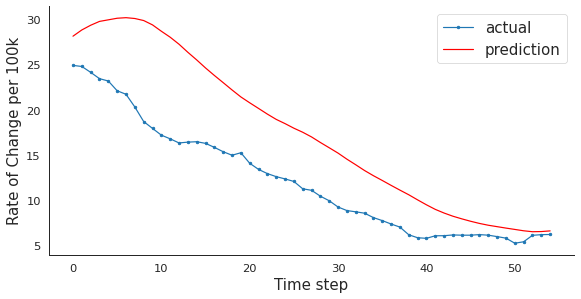

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 200)               92000     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 4976688.5
Train Root Mean Squared Error: 0.7912852060665103
Test Mean Absolute Percentage Error: 33.354794
Test Root Mean Squared Error: 4.764990949535525


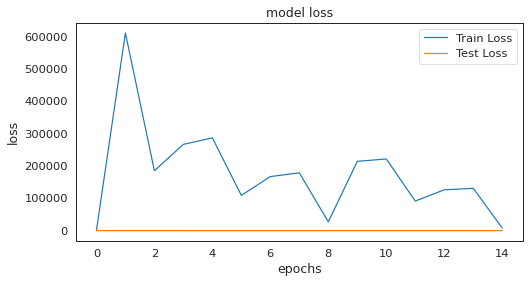

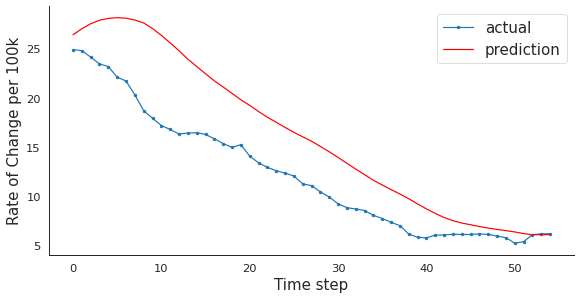

India
Statistics=55.747, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: -0.865745074313713
Skewness of normal distribution: 0.6305615342564133


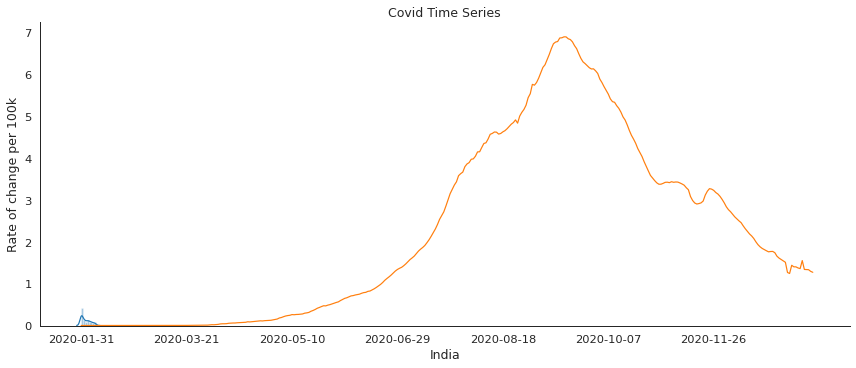

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               46000     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 208849.73
Train Root Mean Squared Error: 0.3696010459809896
Test Mean Absolute Percentage Error: 20.56606
Test Root Mean Squared Error: 0.4566589247037147


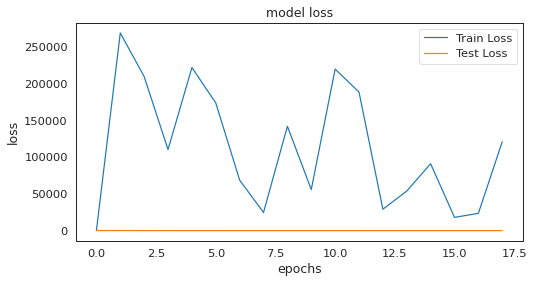

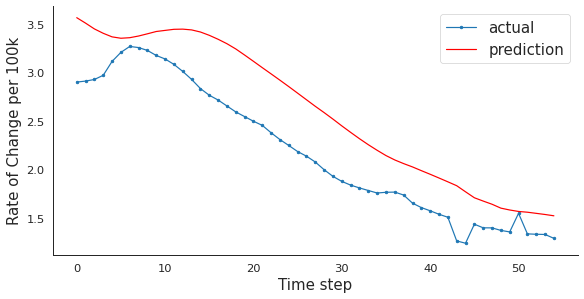

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 200)               92000     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 550211.3
Train Root Mean Squared Error: 0.28867804534483615
Test Mean Absolute Percentage Error: 19.555239
Test Root Mean Squared Error: 0.4293773337003202


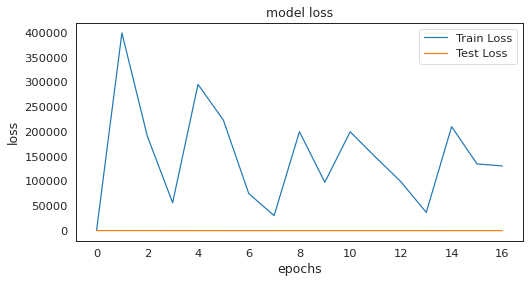

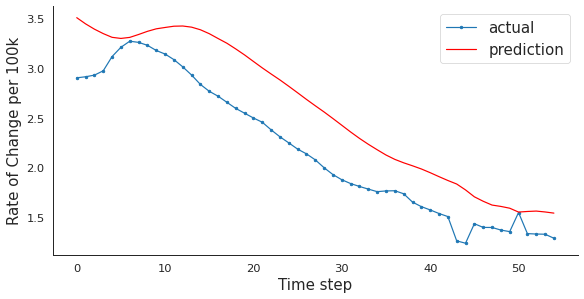

Ireland
Statistics=392.516, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 29.88152291634332
Skewness of normal distribution: 5.215712165578896


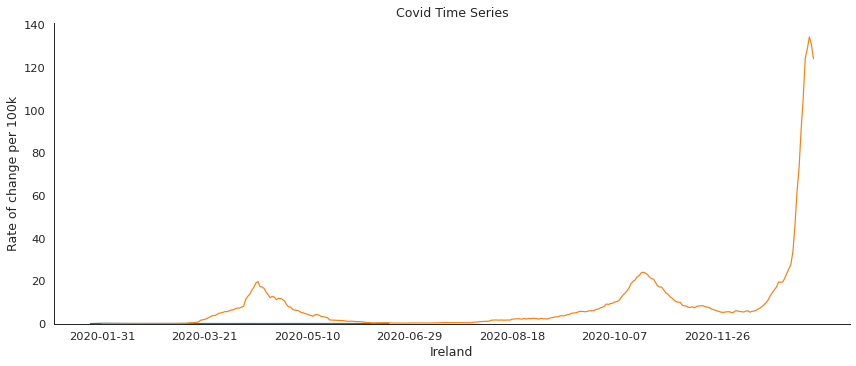

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 14823742.0
Train Root Mean Squared Error: 1.9863493962634196
Test Mean Absolute Percentage Error: 25.986275
Test Root Mean Squared Error: 16.56589100759229


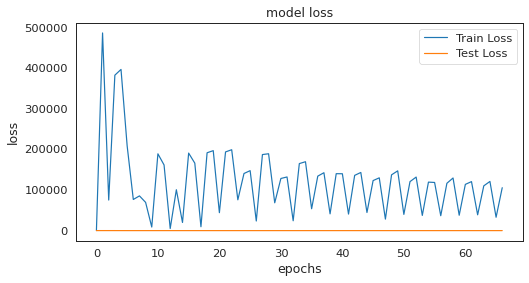

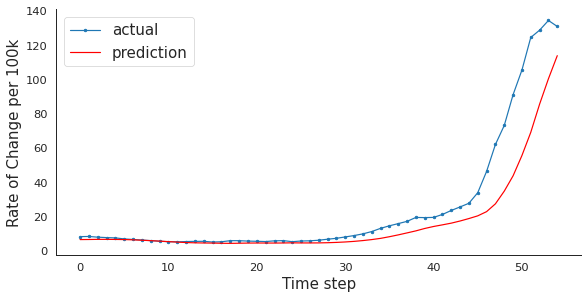

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 200)               92000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 9674695.0
Train Root Mean Squared Error: 1.2157556324524967
Test Mean Absolute Percentage Error: 17.036234
Test Root Mean Squared Error: 10.969038367366924


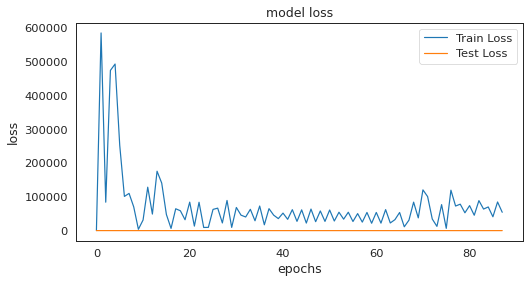

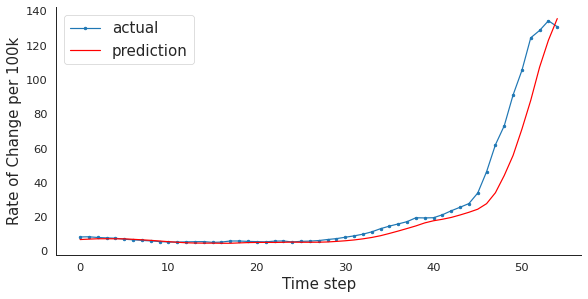

Israel
Statistics=110.488, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 2.144567374437737
Skewness of normal distribution: 1.6848143384337304


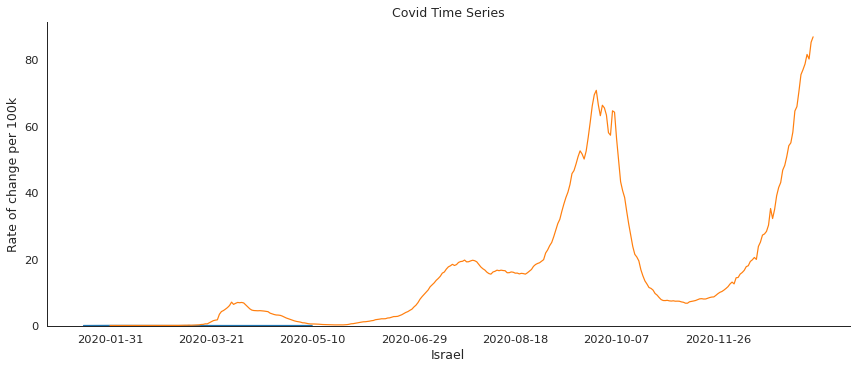

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 960961.44
Train Root Mean Squared Error: 2.1801567347568396
Test Mean Absolute Percentage Error: 9.91141
Test Root Mean Squared Error: 3.4745955944826115


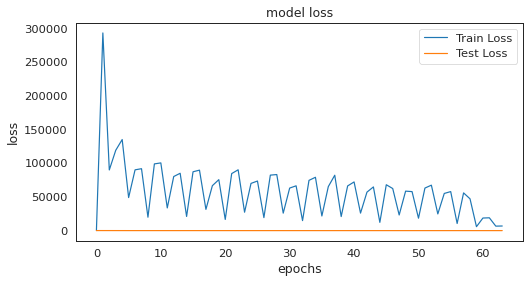

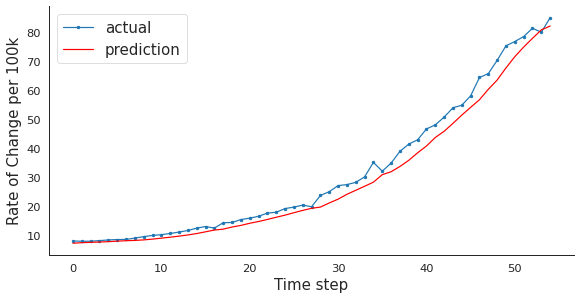

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 200)               92000     
_________________________________________________________________
dropout_14 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 4133806.8
Train Root Mean Squared Error: 4.575551899491939
Test Mean Absolute Percentage Error: 26.481056
Test Root Mean Squared Error: 10.028454202990584


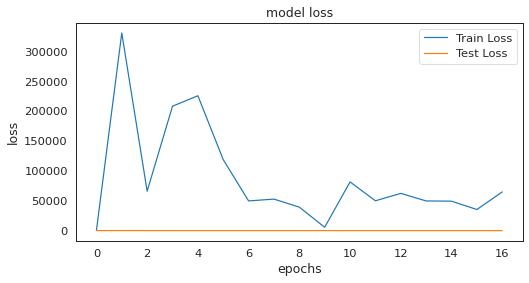

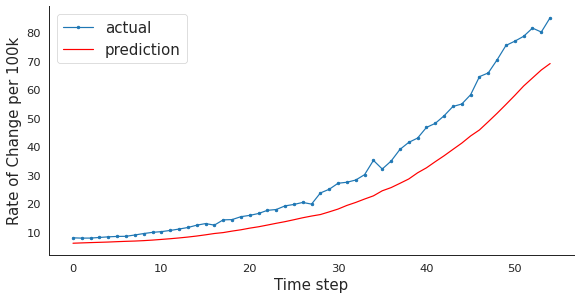

Spain
Statistics=35.124, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: -0.08989030275484522
Skewness of normal distribution: 0.8704419885584432


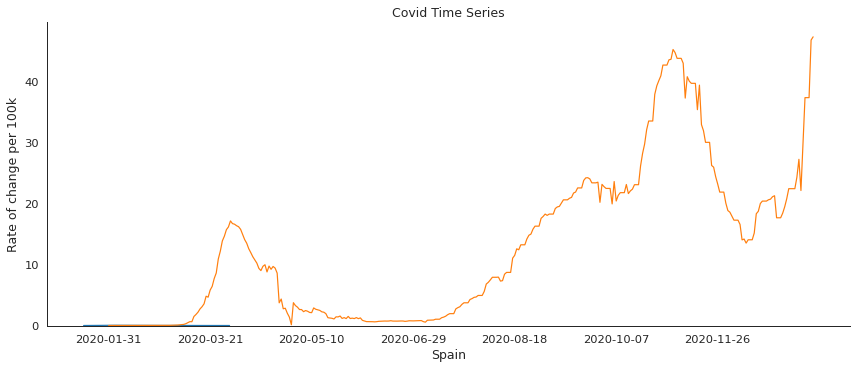

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 4482561.5
Train Root Mean Squared Error: 2.2293456569159376
Test Mean Absolute Percentage Error: 21.152475
Test Root Mean Squared Error: 6.570826385753543


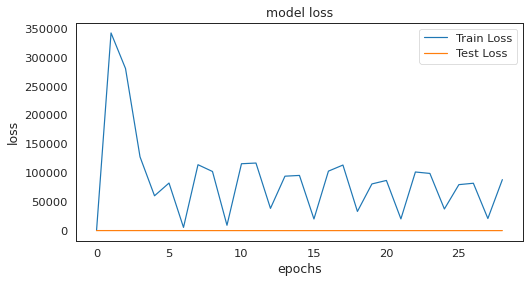

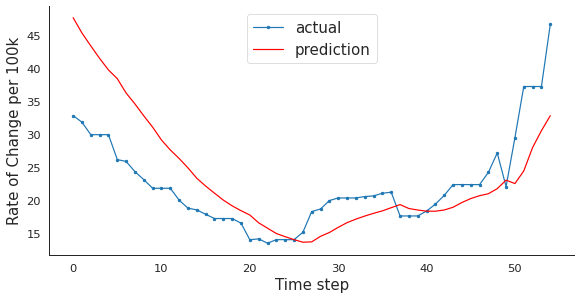

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 200)               92000     
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 1137871.9
Train Root Mean Squared Error: 2.178455703563838
Test Mean Absolute Percentage Error: 21.229406
Test Root Mean Squared Error: 6.4165587867782214


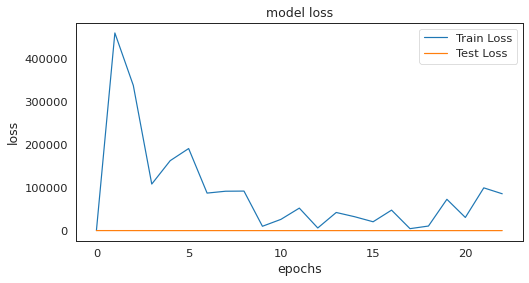

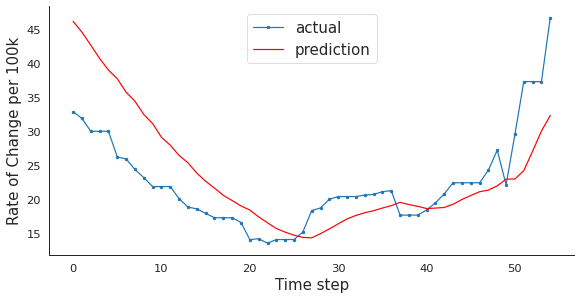

Turkey
Statistics=422.744, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 35.01588434524786
Skewness of normal distribution: 5.813370641860739


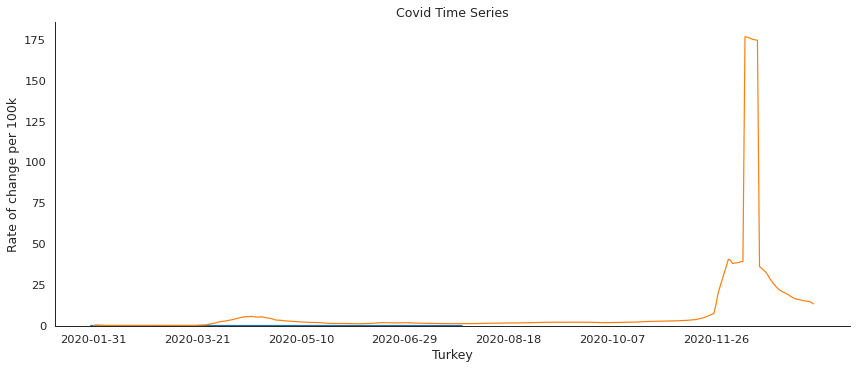

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 19326784.0
Train Root Mean Squared Error: 0.6229508004978974
Test Mean Absolute Percentage Error: 95.27291
Test Root Mean Squared Error: 52.23645458994746


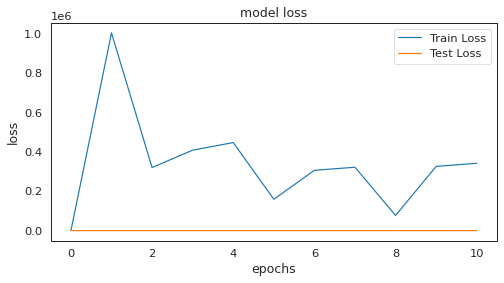

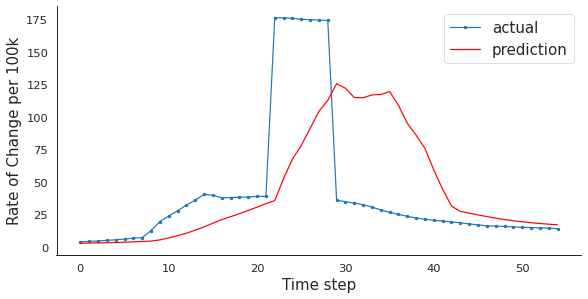

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 200)               92000     
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 70804110.0
Train Root Mean Squared Error: 1.0245285338656982
Test Mean Absolute Percentage Error: 75.002716
Test Root Mean Squared Error: 47.891154562018414


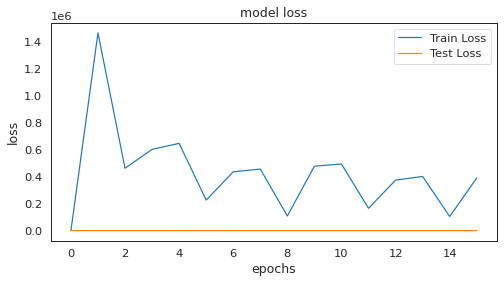

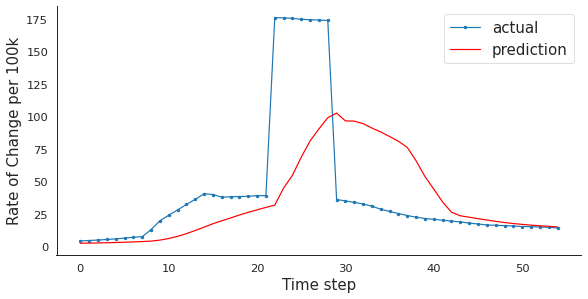

United Kingdom
Statistics=158.651, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 4.479412381971872
Skewness of normal distribution: 2.1074748803580627


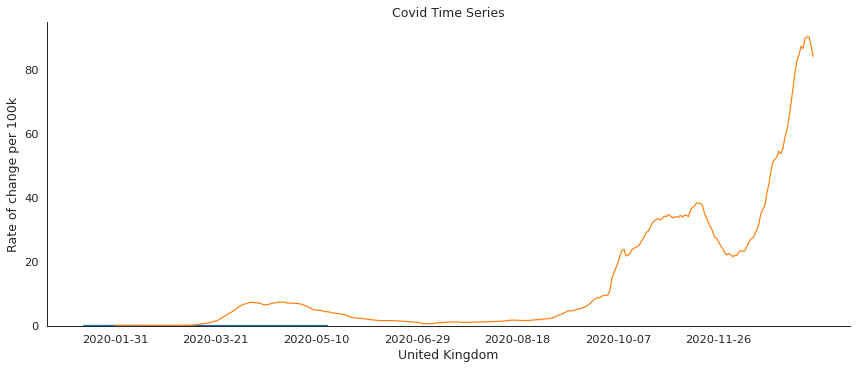

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 301.14197
Train Root Mean Squared Error: 1.3851750940624288
Test Mean Absolute Percentage Error: 18.964655
Test Root Mean Squared Error: 9.560837032658997


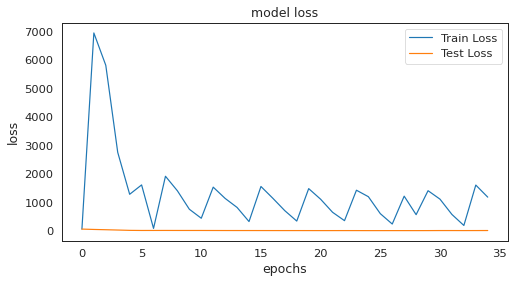

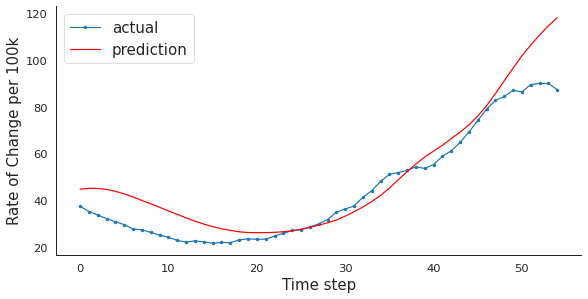

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 521.7221
Train Root Mean Squared Error: 0.9424248072091878
Test Mean Absolute Percentage Error: 7.7810583
Test Root Mean Squared Error: 3.854672003949159


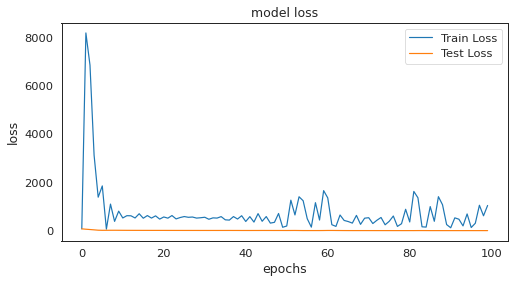

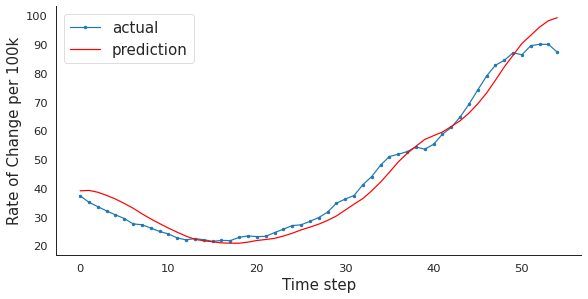

United States
Statistics=73.415, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 0.6492585446686965
Skewness of normal distribution: 1.3758659052320532


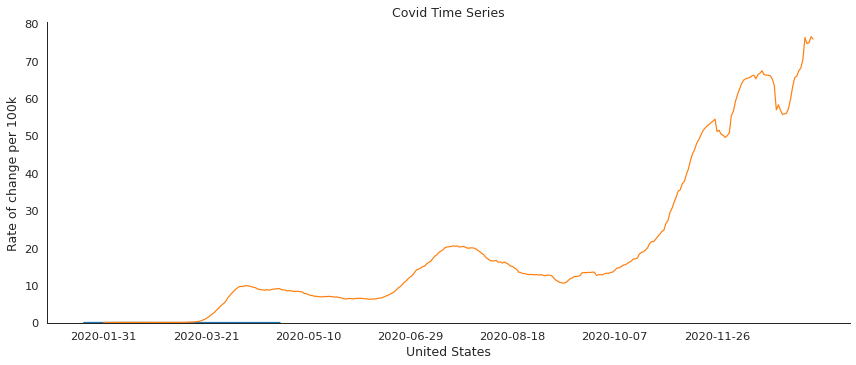

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 264582.47
Train Root Mean Squared Error: 1.223442483424085
Test Mean Absolute Percentage Error: 7.405767
Test Root Mean Squared Error: 5.725476064756391


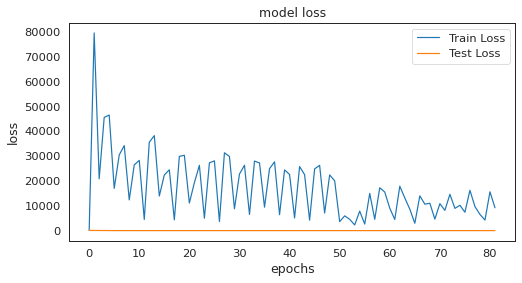

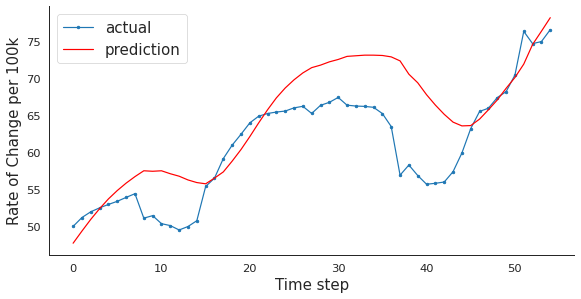

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_22 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 473917.97
Train Root Mean Squared Error: 0.9535966347330417
Test Mean Absolute Percentage Error: 7.6257296
Test Root Mean Squared Error: 5.5990407808662965


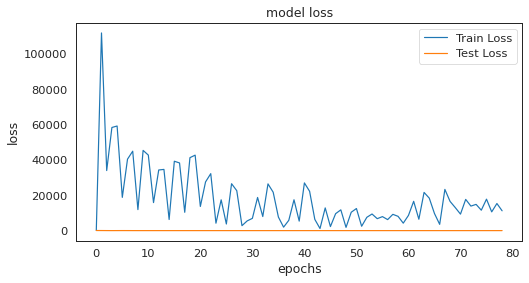

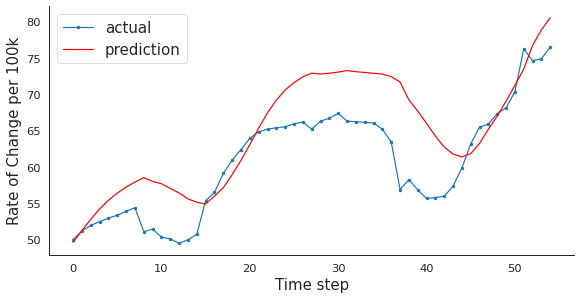

In [5]:
for col in casediff.columns:
    print(col)
    raw_seq = casediff[col]
    normtest(raw_seq)
    history, test_predict, Y_test = lstmseq2(raw_seq)
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();
    aa=[x for x in range(len(test_predict))]
    plt.figure(figsize=(8,4))
    plt.plot(aa, Y_test[0], marker='.', label="actual")
    plt.plot(aa, test_predict[:,0], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Rate of Change per 100k', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();
    history, test_predict, Y_test = lstmbi2(raw_seq)
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();
    aa=[x for x in range(len(test_predict))]
    plt.figure(figsize=(8,4))
    plt.plot(aa, Y_test[0], marker='.', label="actual")
    plt.plot(aa, test_predict[:,0], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Rate of Change per 100k', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

Belgium
Statistics=237.647, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 9.041908676070287
Skewness of normal distribution: 3.0027701224904213


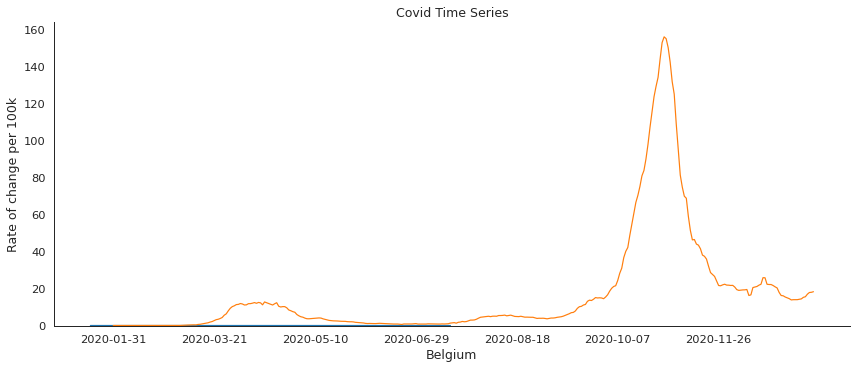

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 6519136.0
Train Root Mean Squared Error: 5.649902663316764
Test Mean Absolute Percentage Error: 26.152372
Test Root Mean Squared Error: 9.012851061438996


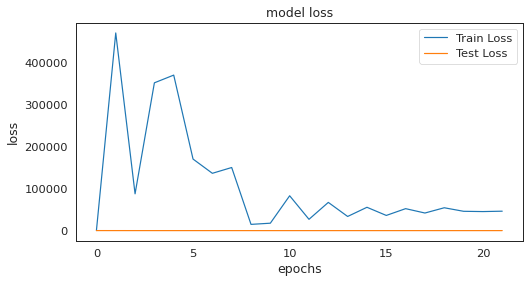

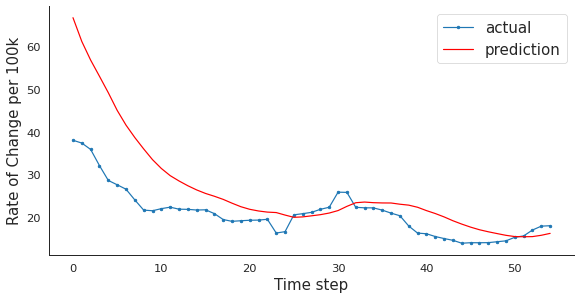

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 18126750.0
Train Root Mean Squared Error: 5.979115840064123
Test Mean Absolute Percentage Error: 21.740543
Test Root Mean Squared Error: 7.600003014919525


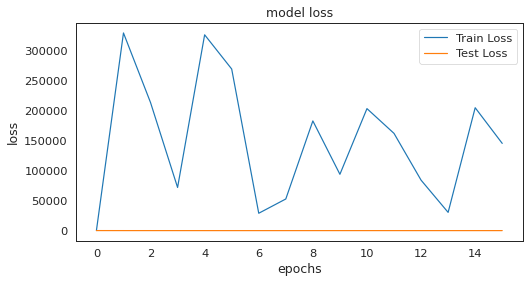

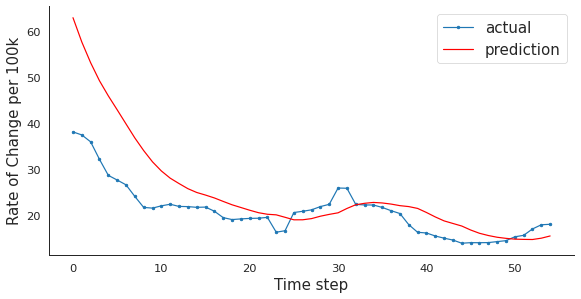

Chile
Statistics=66.014, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 1.1402225567657691
Skewness of normal distribution: 1.1865721038567636


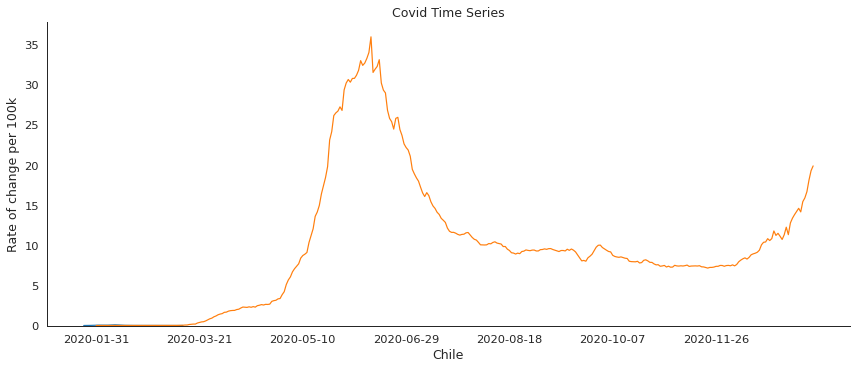

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 3469099.2
Train Root Mean Squared Error: 2.5491560469599532
Test Mean Absolute Percentage Error: 10.534487
Test Root Mean Squared Error: 1.7290178281818813


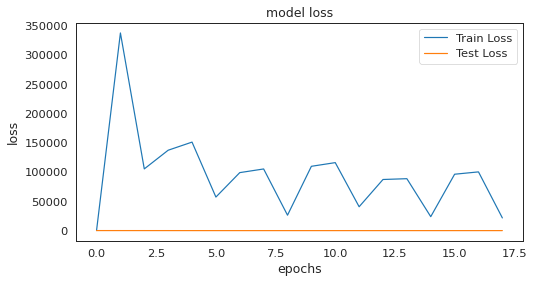

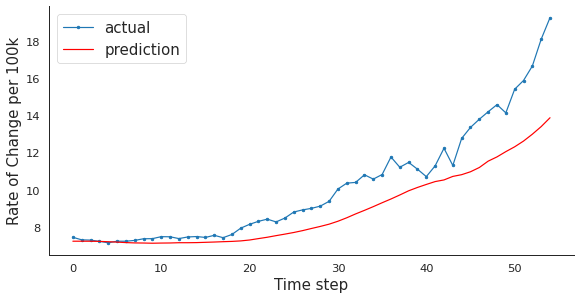

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 1934810.8
Train Root Mean Squared Error: 2.3963380441127837
Test Mean Absolute Percentage Error: 11.048189
Test Root Mean Squared Error: 1.717899022744266


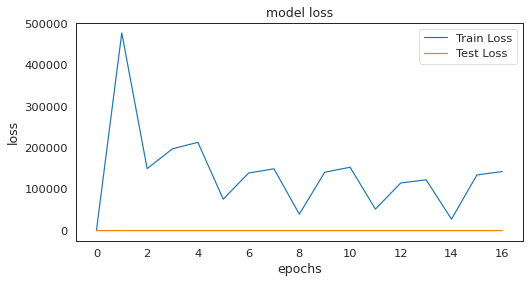

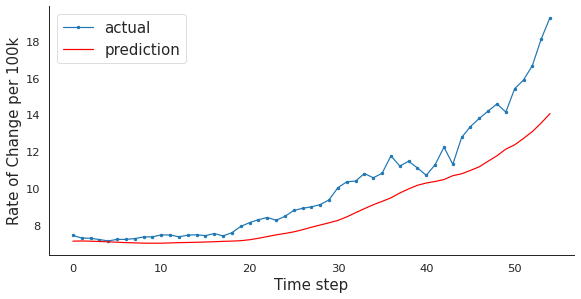

China (People's Republic of)
Statistics=313.878, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 15.703735874430773
Skewness of normal distribution: 4.046493922433115


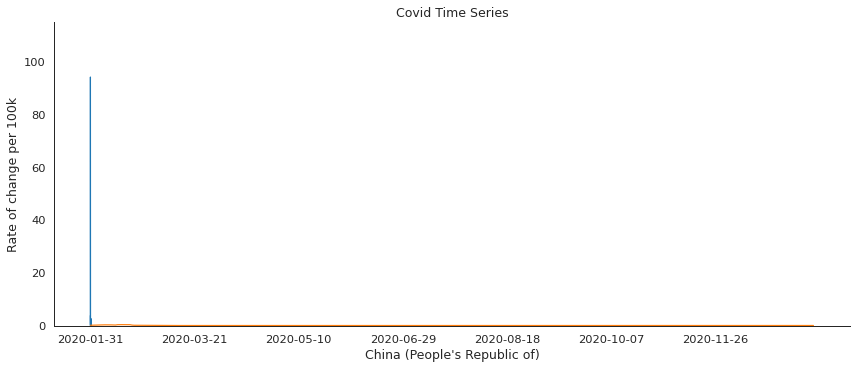

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_27 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 108.04443
Train Root Mean Squared Error: 0.045525451996917134
Test Mean Absolute Percentage Error: 101.88177
Test Root Mean Squared Error: 0.006541568277651114


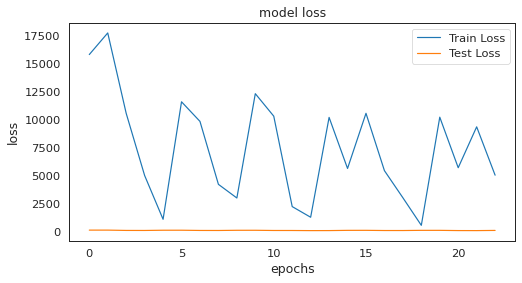

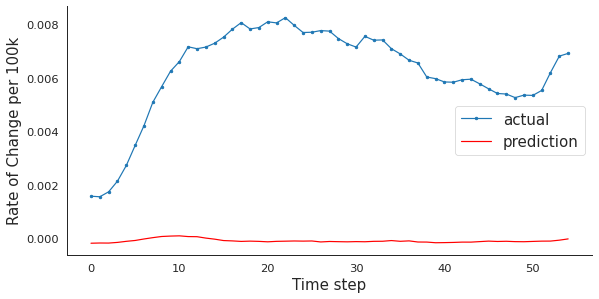

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 146.42963
Train Root Mean Squared Error: 0.04288578832789612
Test Mean Absolute Percentage Error: 111.89482
Test Root Mean Squared Error: 0.007040385467566736


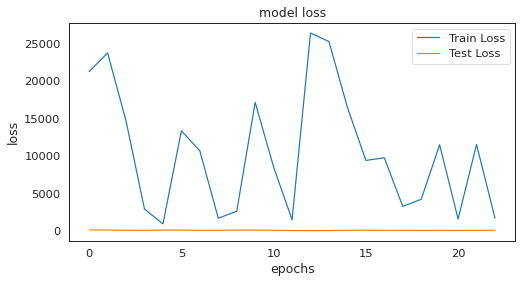

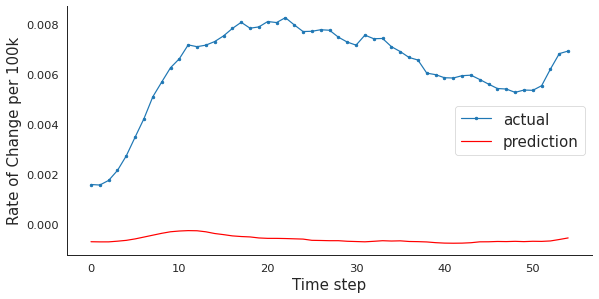

Greece
Statistics=136.281, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 2.8655607849090963
Skewness of normal distribution: 1.9714660770965662


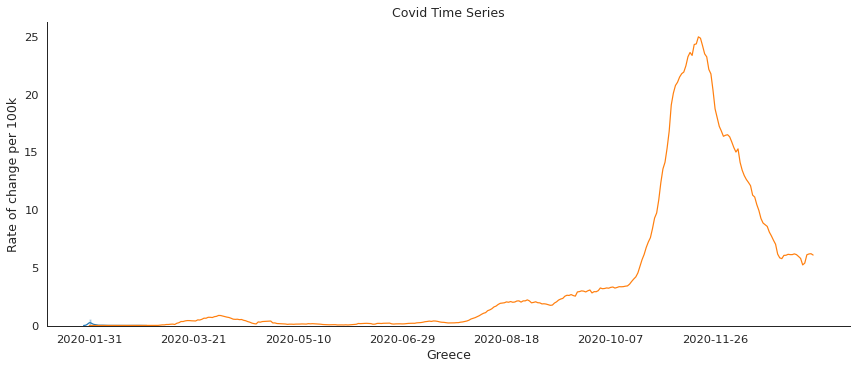

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 3580494.2
Train Root Mean Squared Error: 0.7722090049511037
Test Mean Absolute Percentage Error: 44.217567
Test Root Mean Squared Error: 6.262550212847432


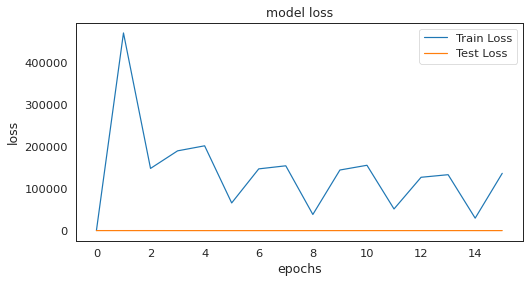

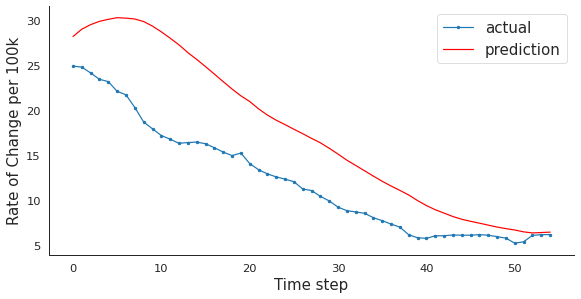

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_15 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_30 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 984287.4
Train Root Mean Squared Error: 0.7244495336549985
Test Mean Absolute Percentage Error: 33.522896
Test Root Mean Squared Error: 5.047800540653212


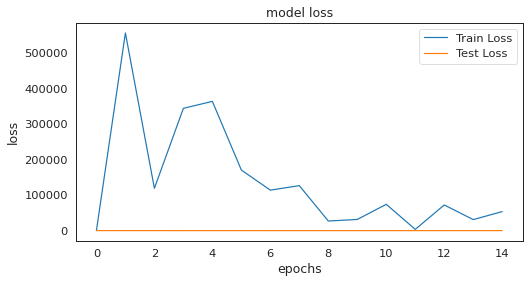

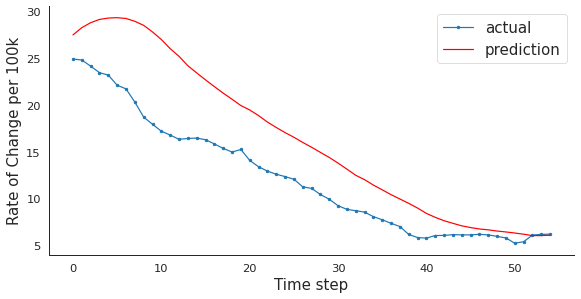

India
Statistics=55.747, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: -0.865745074313713
Skewness of normal distribution: 0.6305615342564133


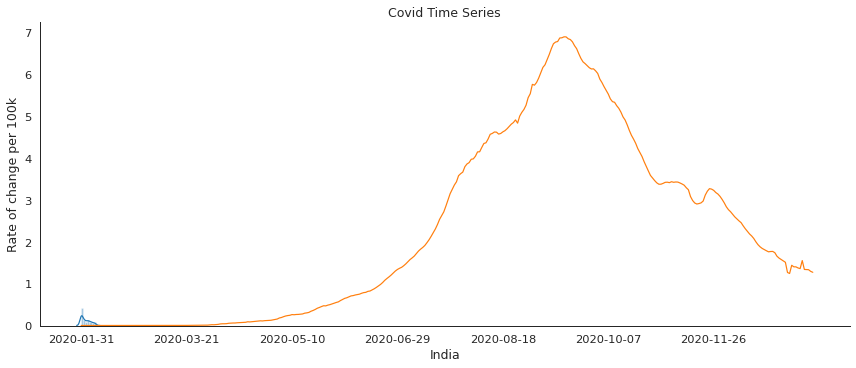

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_31 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 347447.94
Train Root Mean Squared Error: 0.32192219806199257
Test Mean Absolute Percentage Error: 16.085533
Test Root Mean Squared Error: 0.364933430215174


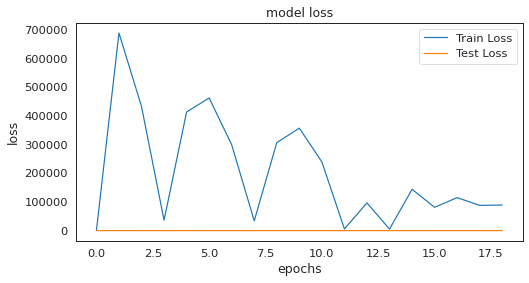

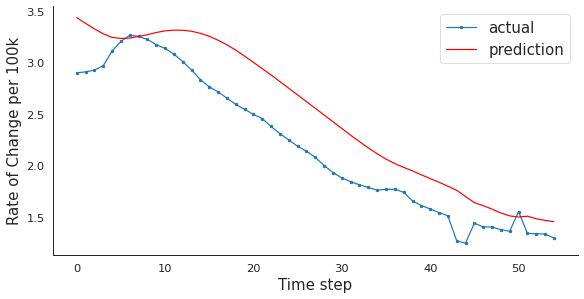

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_16 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_32 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 487346.03
Train Root Mean Squared Error: 0.2897641191771903
Test Mean Absolute Percentage Error: 13.192379
Test Root Mean Squared Error: 0.29975401274662516


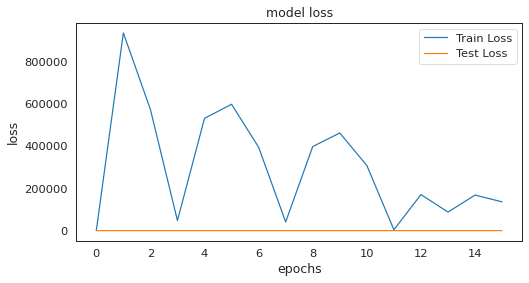

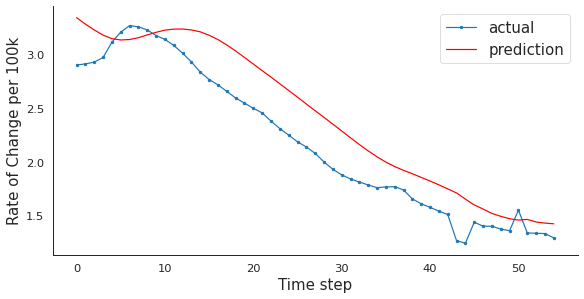

Ireland
Statistics=392.516, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 29.88152291634332
Skewness of normal distribution: 5.215712165578896


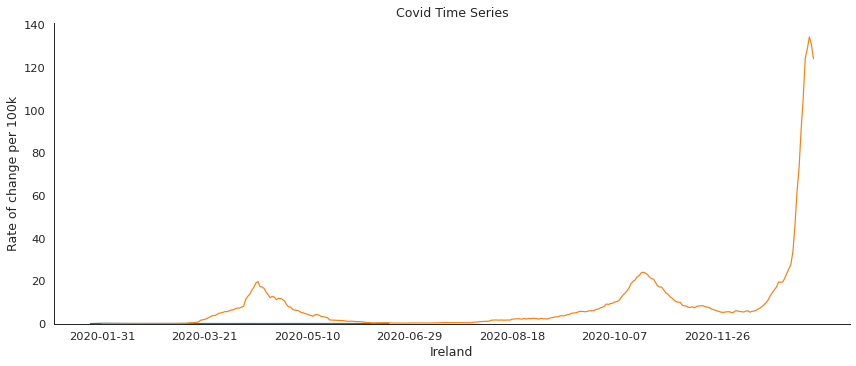

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 12321601.0
Train Root Mean Squared Error: 1.914978774542349
Test Mean Absolute Percentage Error: 25.946205
Test Root Mean Squared Error: 16.990413282018288


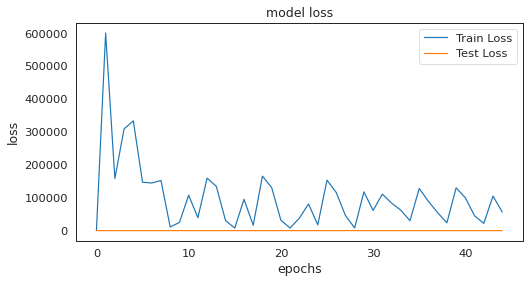

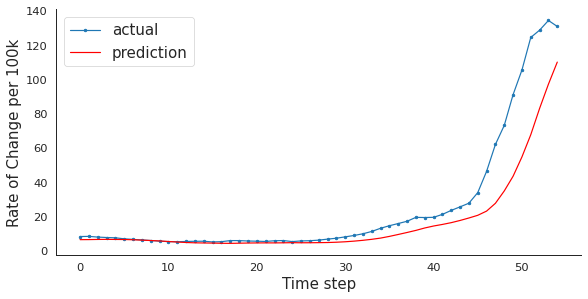

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_17 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_34 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 6516369.0
Train Root Mean Squared Error: 1.4831334771405547
Test Mean Absolute Percentage Error: 20.00457
Test Root Mean Squared Error: 12.909061517106455


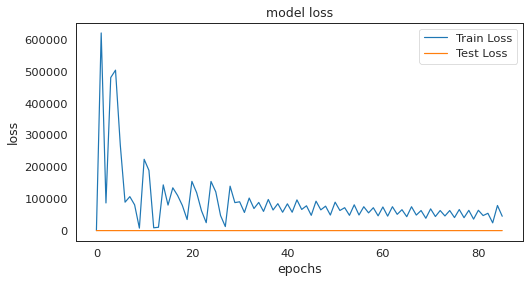

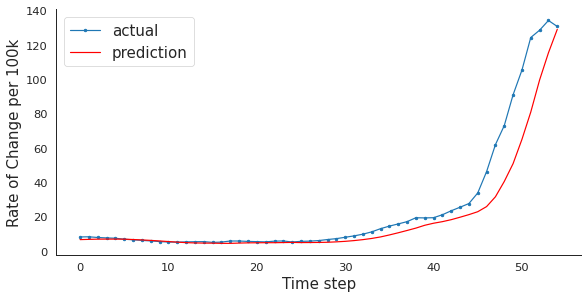

Israel
Statistics=110.488, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 2.144567374437737
Skewness of normal distribution: 1.6848143384337304


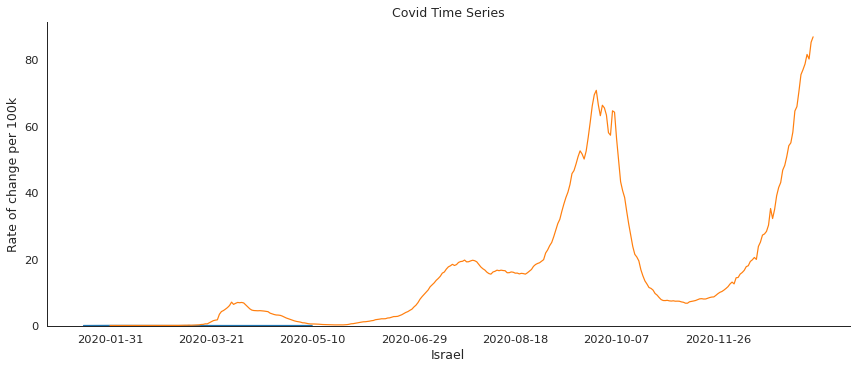

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_35 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 898406.25
Train Root Mean Squared Error: 1.8449482160276125
Test Mean Absolute Percentage Error: 6.276314
Test Root Mean Squared Error: 2.834637204886017


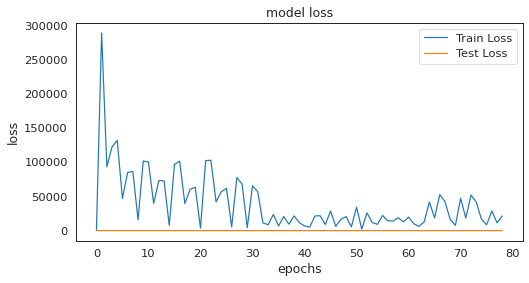

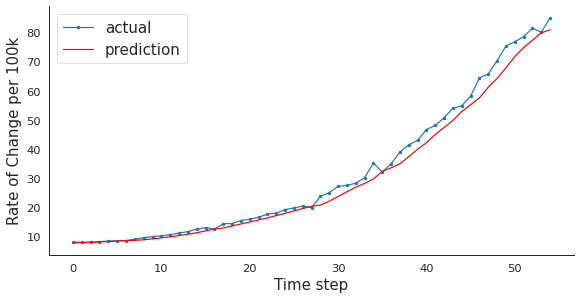

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_36 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 6307684.0
Train Root Mean Squared Error: 4.71184398473454
Test Mean Absolute Percentage Error: 26.061737
Test Root Mean Squared Error: 10.627233445300611


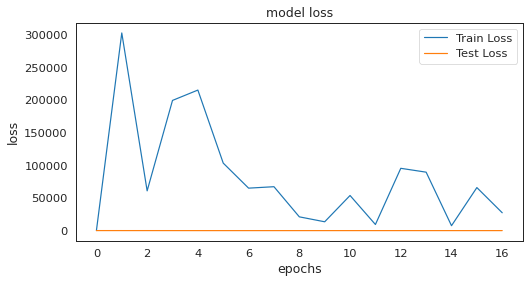

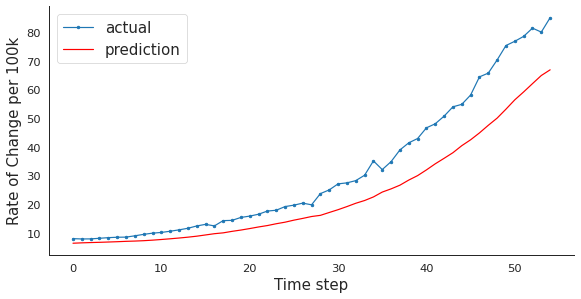

Spain
Statistics=35.124, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: -0.08989030275484522
Skewness of normal distribution: 0.8704419885584432


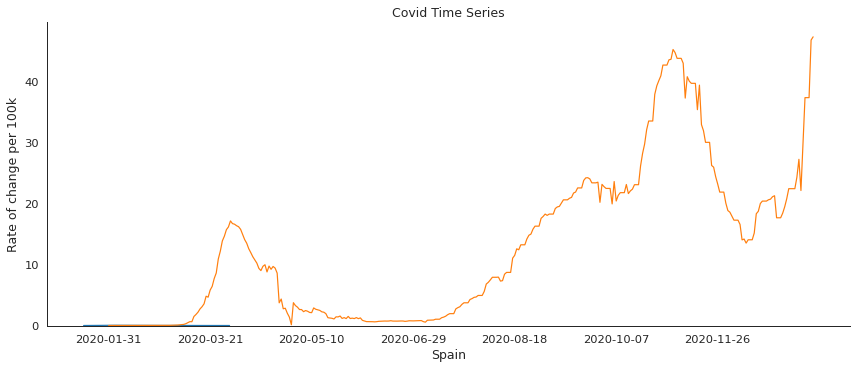

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_37 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 578028.56
Train Root Mean Squared Error: 2.2345406041842186
Test Mean Absolute Percentage Error: 24.148834
Test Root Mean Squared Error: 7.41415227473153


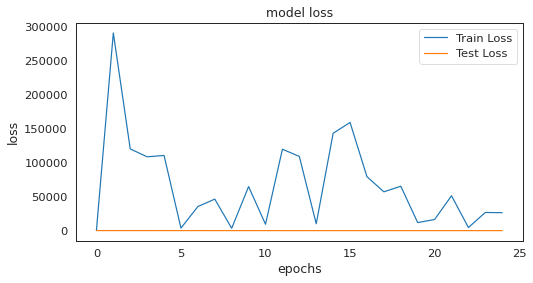

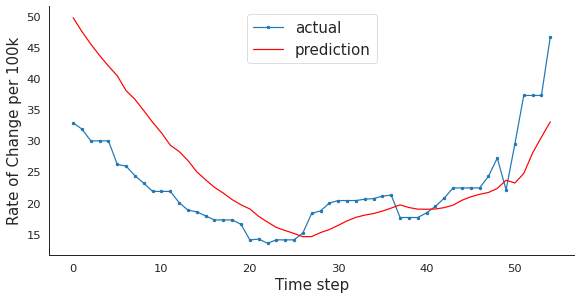

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_19 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_38 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 2389740.2
Train Root Mean Squared Error: 1.961616624758543
Test Mean Absolute Percentage Error: 24.072416
Test Root Mean Squared Error: 7.439182887841502


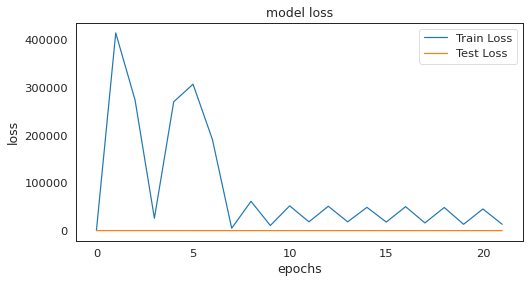

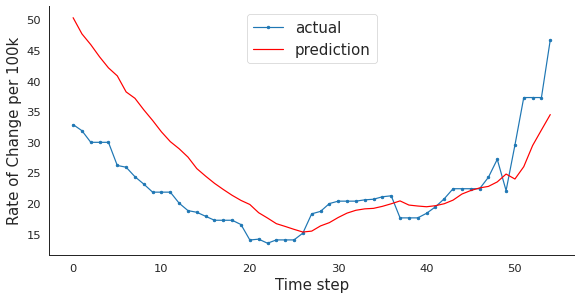

Turkey
Statistics=422.744, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 35.01588434524786
Skewness of normal distribution: 5.813370641860739


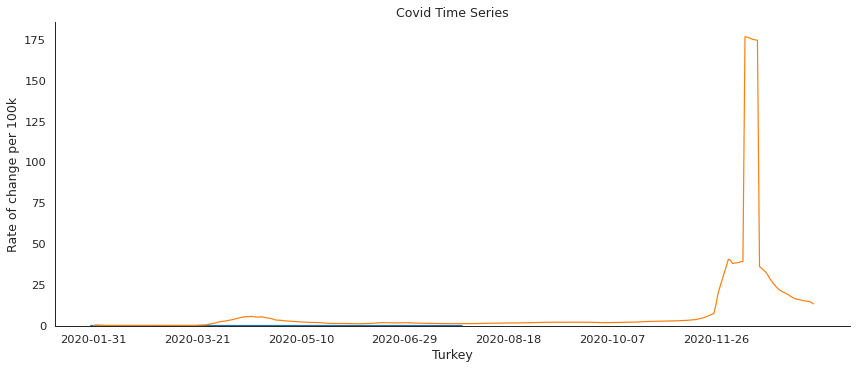

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_39 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 56207200.0
Train Root Mean Squared Error: 0.7820876720017429
Test Mean Absolute Percentage Error: 93.079346
Test Root Mean Squared Error: 52.60319359590663


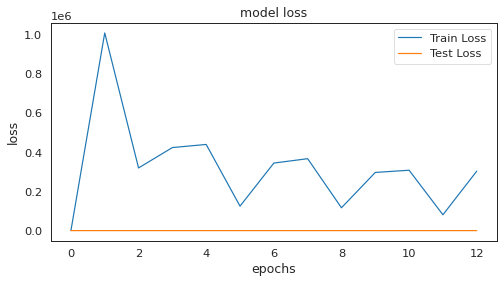

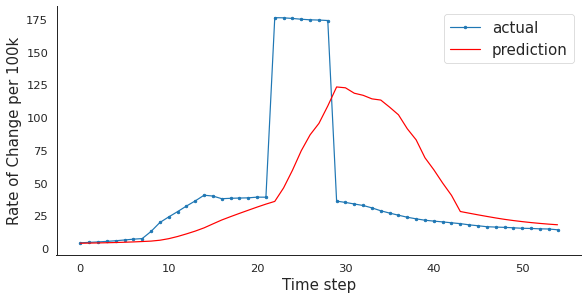

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_20 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_40 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 73944970.0
Train Root Mean Squared Error: 1.0686921545427848
Test Mean Absolute Percentage Error: 77.90846
Test Root Mean Squared Error: 48.83620620604143


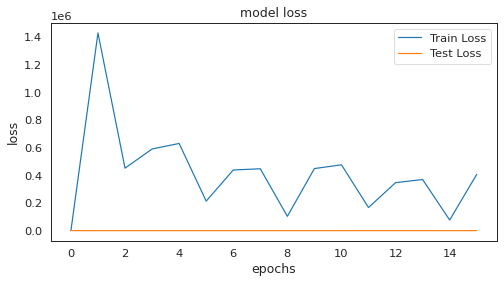

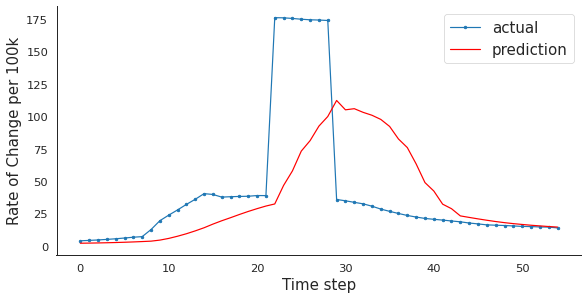

United Kingdom
Statistics=158.651, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 4.479412381971872
Skewness of normal distribution: 2.1074748803580627


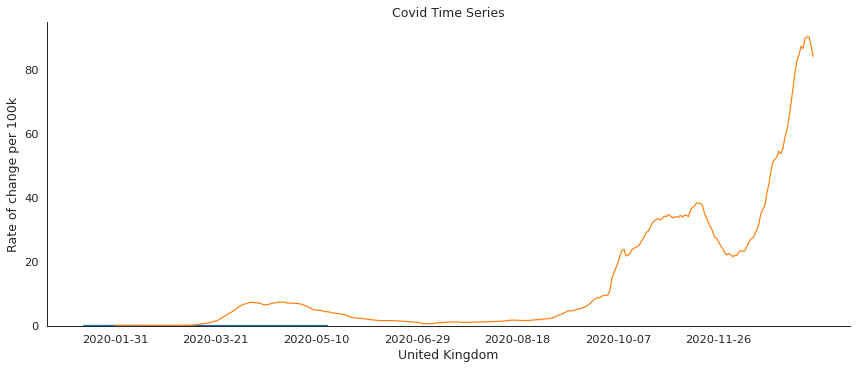

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_41 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 480.1208
Train Root Mean Squared Error: 1.0611643934422859
Test Mean Absolute Percentage Error: 11.969849
Test Root Mean Squared Error: 6.6025484729568635


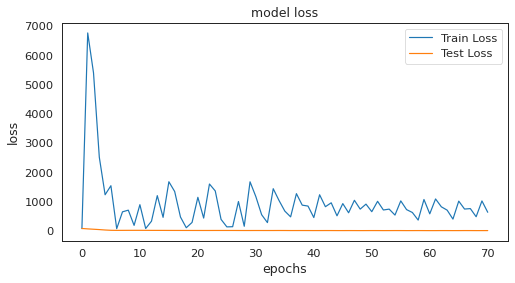

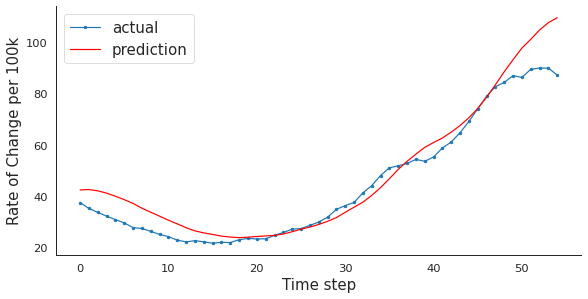

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_21 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_42 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 903.10944
Train Root Mean Squared Error: 1.385158765352556
Test Mean Absolute Percentage Error: 18.76813
Test Root Mean Squared Error: 9.940903196369957


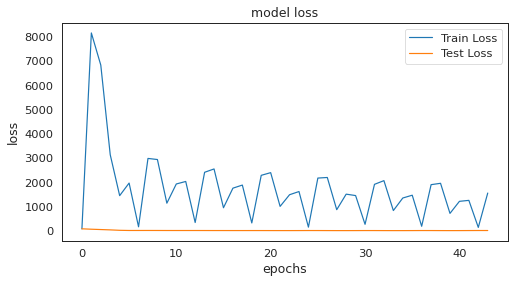

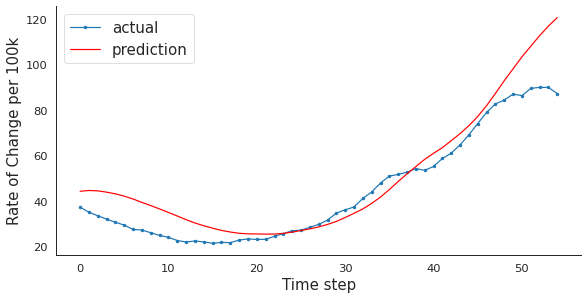

United States
Statistics=73.415, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 0.6492585446686965
Skewness of normal distribution: 1.3758659052320532


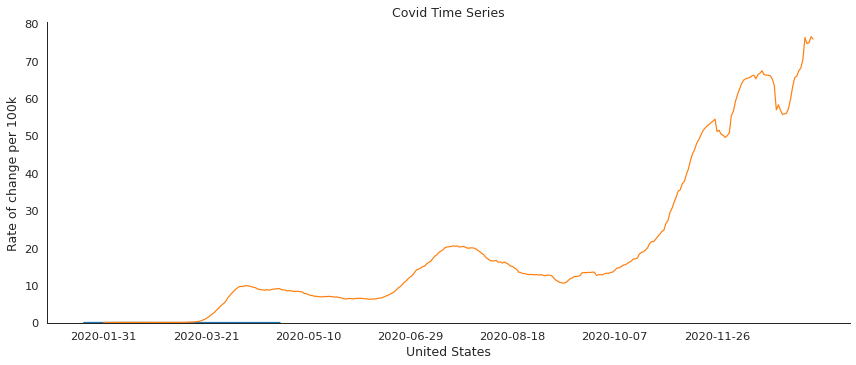

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dropout_43 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 101       
Total params: 46,101
Trainable params: 46,101
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 302818.38
Train Root Mean Squared Error: 1.1051030714217671
Test Mean Absolute Percentage Error: 5.7095876
Test Root Mean Squared Error: 4.130796765779403


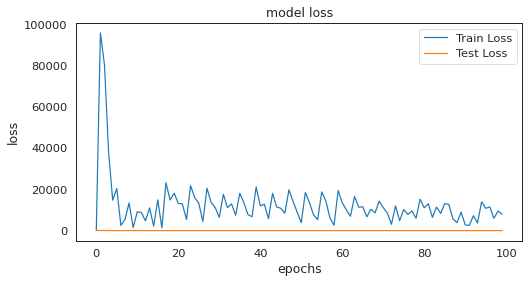

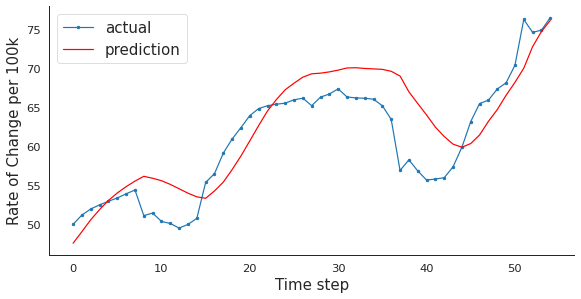

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_22 (Bidirectio (None, 200)               92000     
_________________________________________________________________
dropout_44 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 201       
Total params: 92,201
Trainable params: 92,201
Non-trainable params: 0
_________________________________________________________________
Train Mean Absolute Percentage Error: 411470.8
Train Root Mean Squared Error: 1.1436668942123476
Test Mean Absolute Percentage Error: 7.1491704
Test Root Mean Squared Error: 5.398002498406196


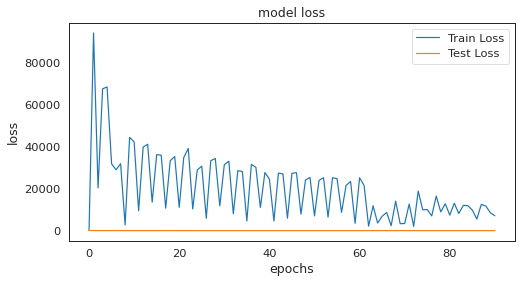

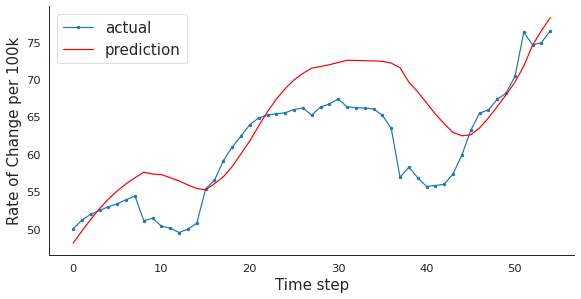

In [6]:
for col in deathdiff.columns:
    print(col)
    raw_seq = casediff[col]
    normtest(raw_seq)
    history, test_predict, Y_test = lstmseq2(raw_seq)
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();
    aa=[x for x in range(len(test_predict))]
    plt.figure(figsize=(8,4))
    plt.plot(aa, Y_test[0], marker='.', label="actual")
    plt.plot(aa, test_predict[:,0], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Rate of Change per 100k', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();
    history, test_predict, Y_test = lstmbi2(raw_seq)
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();
    aa=[x for x in range(len(test_predict))]
    plt.figure(figsize=(8,4))
    plt.plot(aa, Y_test[0], marker='.', label="actual")
    plt.plot(aa, test_predict[:,0], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Rate of Change per 100k', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();